Example of the process of doing DEMs for all orbits for a given observation of an AR – where we don't window out any intervals because of shifts, etc. Instead, we will save energy-specific information about the percent of NuSTAR emission in the chosen region as a function of time, for later inspection. This will help identify cases where pointing shifts might cause unphysical distortion to the DEM inputs. 

Note: auto-download of an AIA file (for use in the initial co-alignmnet) will break while the JSOC is still down. We will add a thing where you can point to an existing AIA file instead.

Overview:

- Define orbits
- Run time interval selection
- Examine resulting intervals
- Manually establish a co-alignment shift between NuSTAR and AIA
- Automatically find co-alignment shifts + make regions for all other time intervals (note: this relies on the assumption that the COM is a good representation of the location of the brightest source, i.e. that the NuSTAR data is primarially one blob).
- Save AIA region files for NCCS input
- NOT IN THIS NOTEBOOK: YOU THEN TAKE THOSE AND MAKE AIA INPUTS ON THE NCCS
- Conduct AIA/NuSTAR DEMs as a function of time, given all the above
- Plot results.
- Print some stats about "left out" times.

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

# #import nustar_dem_prep as nu
import images_and_coalignment as iac
import time_interval_selection as tis
import nustar_utilities as nuutil
import gauss2D as g2d
import nustar_dem_prep as nu


# import os
# # For macOS
# def play_sound():
#     os.system("afplay /System/Library/Sounds/Glass.aiff")

import pickle
import pathlib
import importlib
from astropy import units as u
import numpy as np


In [2]:
key = '22-apr-16_2'

with open('all_targets.pickle', 'rb') as f:
    data = pickle.load(f)
    
method = data[key]['method']
ARDict = data[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']

if method=='double':
    gauss_stats = ARDict['gauss_stats']
    sep_axis = gauss_stats[0][0]
else:
    sep_axis = ''

In [3]:
obsids=[]
for id in id_dirs:
    evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
    obsids.append(obsid)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    

17-20-54 18-11-18
18-47-44 19-48-01
20-24-27 21-04-55
22-01-10 23-01-26


In [4]:
importlib.reload(iac)
aia_dir = '/Users/jmdunca2/sample_aia/sample_aia/'


aiamaps = iac.get_orbit_aiamaps(aia_dir, id_dirs, wave=94)   

/Users/jmdunca2/nustar/apr-2016/20101017001/
2016-04-22 17:20:54
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-04-22T172000.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/apr-2016/20101018001/
2016-04-22 18:47:44
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-04-22T184700.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/apr-2016/20101019001/
2016-04-22 20:24:27
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-04-22T202400.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/apr-2016/20101020001/
2016-04-22 22:01:10
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-04-22T220100.12Z.image_lev1.fits']


Goal: write a combined fundtion that, for any number of regions found via any method, plots nustar contours over aia data with all regions shown. 
- In the case of multiple regions (and therefore, multiple different sets of time intervals per orbit), choose the longest time interval for the NuSTAR data.
- In the case where some of the orbits failed TIS for some regions, account for this (only plot sucessful-TIS regions). 

A {'radius': 150.0, 'centerx': <Quantity 986.32119888 arcsec>, 'centery': <Quantity 212.71095973 arcsec>}
B {'radius': 150.0, 'centerx': <Quantity 984.38365922 arcsec>, 'centery': <Quantity 224.78472196 arcsec>}


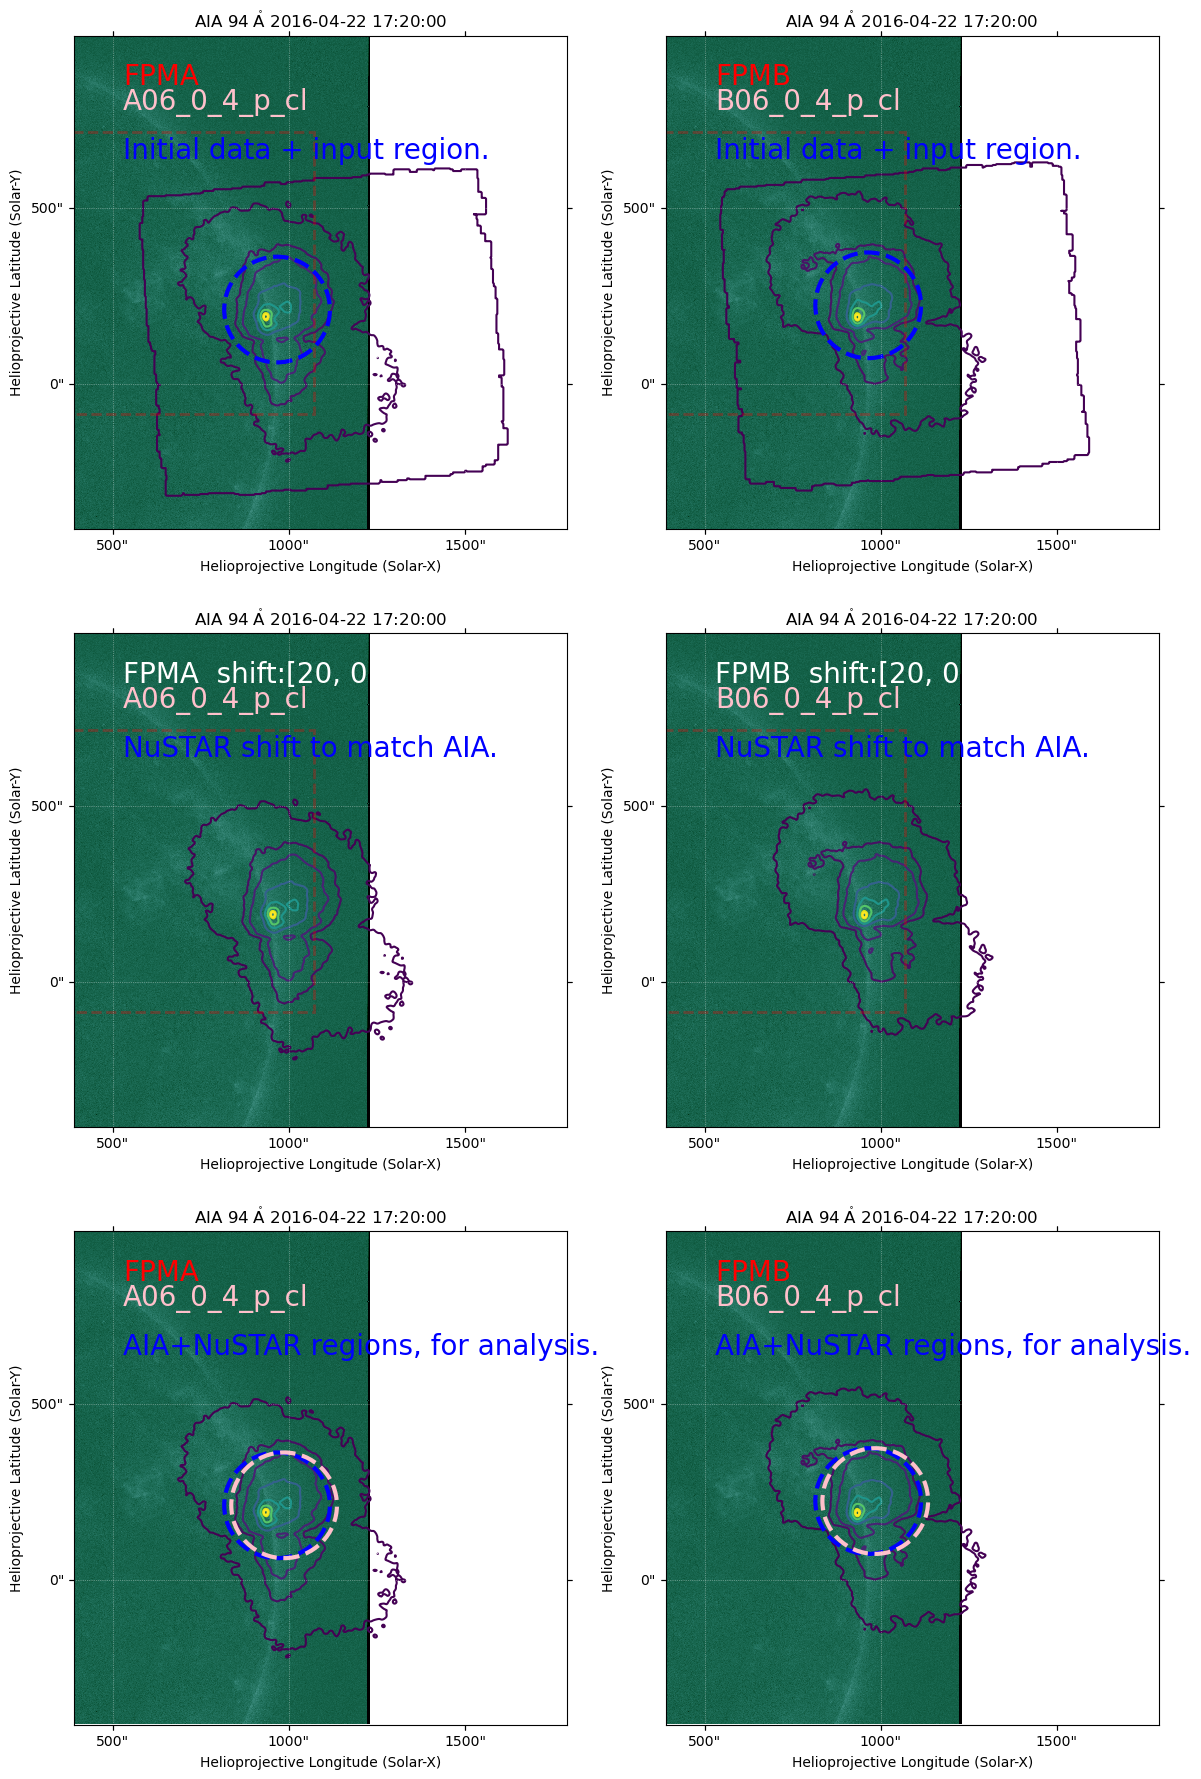

In [6]:
importlib.reload(iac)
aati = iac.per_orbit_region_adjustment(working_dir, id_dirs, obsids, 0, aiamaps, 
                                       nushift=[20, 0], method=method, shush=True, sep_axis=sep_axis)



In [16]:
importlib.reload(iac)

if method in ['input', 'double']:
    if method=='input':
        region_dirs = iac.find_region_dirs(working_dir)
    if method=='double':
        region_dirs = iac.find_direction_dirs(working_dir, sep_axis)

    for r in region_dirs:
        all_time_intervals, all_time_intervals_list = tis.find_all_intervals(r)
        suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, r, key, additional_path=working_dir)

if method=='fit':
    all_time_intervals, all_time_intervals_list = tis.find_all_intervals(working_dir)
    suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, working_dir, key)

0 - 0 11-12-35 11-20-10
0 - 1 11-20-10 11-22-50
0 - 2 11-22-50 11-23-35
0 - 3 11-23-35 11-24-50
0 - 4 11-24-50 11-28-30
0 - 5 11-28-30 11-47-15
0 - 6 11-47-15 11-53-55

1 - 0 16-05-50 16-06-20
1 - 1 16-06-20 16-06-50
1 - 2 16-06-50 16-07-20
1 - 3 16-07-20 16-07-50
1 - 4 16-07-50 16-08-30
1 - 5 16-08-30 16-09-10
1 - 6 16-09-10 16-10-15
1 - 7 16-10-15 16-18-30
1 - 8 16-18-30 16-24-25
1 - 9 16-24-25 16-30-50
1 - 10 16-30-50 16-32-45
1 - 11 16-32-45 16-41-10
1 - 12 16-41-10 17-07-45

2 - 0 17-48-35 17-56-00

3 - 0 19-18-50 19-24-40
3 - 1 19-24-40 19-28-25
3 - 2 19-28-25 19-28-55
3 - 3 19-28-55 19-29-25
3 - 4 19-29-25 19-29-55
3 - 5 19-29-55 19-30-25
3 - 6 19-30-25 19-32-00
3 - 7 19-32-00 19-41-15
3 - 8 19-41-15 19-48-50
3 - 9 19-48-50 19-49-30
3 - 10 19-49-30 19-50-00
3 - 11 19-50-00 19-50-30
3 - 12 19-50-30 19-51-00
3 - 13 19-51-00 19-52-15
3 - 14 19-52-15 19-53-20
3 - 15 19-53-20 19-55-05
3 - 16 19-55-05 19-56-50
3 - 17 19-56-50 20-16-25

4 - 0 20-52-30 20-56-05
4 - 1 20-56-05 21-03-05
4

In [11]:
method

'fit'

In [3]:
# firl = '/Users/jmdunca2/do-dem/initial_dem_8jun20/19-54-59_20-00-54/19-54-59_20-00-54_aia_region.pickle'
#firl = '/Users/jmdunca2/do-dem/initial_dem_11sep17/all_aia_dicts_11-sep-17_post/orbit_80310212001/17-32-30_17-33-00_aia_prep.pickle'
#firl = '/Users/jmdunca2/do-dem/initial_dem_19feb16/all_aia_dicts_19-feb-16/orbit_20102014001/23-44-55_00-09-50_aia_prep.pickle'
#firl = '/Users/jmdunca2/do-dem/initial_dem_29may18_2/all_aia_dicts_29-may-18_2/orbit_80410206001/21-16-55_21-24-25_aia_prep.pickle'
firl = '/Users/jmdunca2/do-dem/initial_dem_22apr16_2/all_aia_dicts_22-apr-16_2/orbit_20101017001/17-20-55_18-11-15_aia_prep.pickle'


#orbit_20101019001/20-24-30_20-38-45_aia_prep.pickle
#orbit_20101020001/22-01-10_22-06-25_aia_prep.pickle

with open(firl, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
data

dict_keys(['radius', 'centerx', 'centery', 'time_interval'])


{'radius': 150.0,
 'centerx': <Quantity 984.38365922 arcsec>,
 'centery': <Quantity 224.78472196 arcsec>,
 'time_interval': <Time object: scale='utc' format='datetime' value=[datetime.datetime(2016, 4, 22, 17, 20, 55)
  datetime.datetime(2016, 4, 22, 18, 11, 15)]>}

In [ ]:
dict_={}
dict_['hi'+str(0)]='hey'
dict_

In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals:
#     lead_intervals.append(at[0])

# reference_interval=time_interval


# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
# importlib.reload(oa)
# import pickle

# orbit_ind=0

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[0, 0]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# #IF YOU WANT TO REVISE THE STARTING SHIFT SOMEWHERE OTHER THAN JUST AT THE VERY FIRST ORBIT - NEXT 2 CELLS

# importlib.reload(oa)
# import pickle

# orbit_ind=3

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[30, -40]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals[3:]:
#     lead_intervals.append(at[0])

# reference_interval=time_interval

# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
importlib.reload(oa)
suborbit_dirs = oa.make_all_aia_dicts(all_time_intervals, working_dir, key)
print(set(suborbit_dirs))

In [ ]:
# import glob

# #Set path to obsid directory - initial pipeline should have been run already.
# ind=0
# datapath=id_dirs[ind]
# obsid=obsids[ind]

# evt_data, hdr = ia.return_submap(datapath=datapath, fpm='A', return_evt_hdr=True)
# time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
# timerange = [time0.tt.datetime, time1.tt.datetime]
# from datetime import timezone
# timerange = [t.replace(tzinfo=timezone.utc) for t in timerange]

# #Comment second line if you're not using this same example nustar orbit
# #Edit it to include only the desired time interval (default- all times in file) once you've run this once
# #timerange=[]
# #timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

# evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
# evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
# hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
# hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

# import lightcurves as lc

# importlib.reload(lc)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
#                               livetime_corr=False, save_dir=working_dir)

# lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
#                            timerange=timerange, save_dir=working_dir)